In [1]:
import mne
import numpy as np
import matplotlib.pyplot as plt
import os
import augmentation_time_and_amplitude as aug


In [2]:
def fast_scandir(dirname):
    subfolders= [f.path for f in os.scandir(dirname) if f.is_dir()]
    for dirname in list(subfolders):
        subfolders.extend(fast_scandir(dirname))
    return subfolders

def fast_scanfiles(dirname, contains=None):
    subfiles = [f.path for f in os.scandir(dirname) if f.is_file()]
    if contains != None:
        subfiles = [i for i in subfiles if contains in i ]
    return subfiles

def fast_scanfiles_subjfiles(dirname, contains=None):
    subfolders = fast_scandir(dirname)
    subfiles = []
    subfiles.extend(fast_scanfiles(dirname, contains=contains))
    for dirs in subfolders:
        subfiles.extend(fast_scanfiles(dirs, contains=contains))
    return subfiles

def make_events_array(n_events, sfreq, tmin, tmax, id):
    SFREQ = sfreq
    first_col = np.array([i*SFREQ*(tmin-tmax)+1 for i in range(n_events)])
    sec_col = np.array([0 for i in range(n_events)])
    third_col = np.array([id for i in range(n_events)])

    vector = np.column_stack((first_col, sec_col, third_col))
    return vector.astype('int')

In [7]:
path_to_raw_files = '/mnt/diskus/epochs_4_augmentation' 

paths_to_augmented_epochs = dict(
    # time_warped='../time_warped_epochs/',
    # amplitude_warped='../amplitude_warped_epochs',
    amplitude_and_time_warped_epochs='../../amplitude_and_time_warped_epochs',
    time_and_amplitude_warped_epochs='../../time_and_amplitude_warped_epochs'
)

for i in paths_to_augmented_epochs.values():
    os.makedirs(i, exist_ok=True)

epoch_pathnames = fast_scanfiles_subjfiles(path_to_raw_files, 
                                           contains='subj')




In [8]:
raw_epochs = mne.read_epochs(epoch_pathnames[0])
TMIN = -1
TMAX = 3
BASELINE = (-1, 0)
info = raw_epochs.info


/tmp/ipykernel_5461/3496696444.py:1: RuntimeWarning: This filename (/mnt/diskus/epochs_4_augmentation/subj_17.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  raw_epochs = mne.read_epochs(epoch_pathnames[0])


In [9]:
def great_augmentator(epoch_pathnames, 
                      apply_time_warp=1,
                      apply_amplitude_warp=1,
                      time_shift_window=[-15, 15],
                      noise_power=7, 
                      fold=5, 
                      depth=0, 
                      max_imf=5, 
                      imf_pick=4
                      ):

    for epoch_path in epoch_pathnames:
        raw_epochs = mne.read_epochs(epoch_path)
        SFREQ = raw_epochs.info['sfreq']
        
        epochs_yes = raw_epochs['yes']
        epochs_no = raw_epochs['no']
        
        info_no, info_yes = epochs_yes.info, epochs_no.info
        event_id_no, event_id_yes = epochs_no.event_id, epochs_yes.event_id
        
        yes_epochs_data = epochs_yes.get_data()
        no_epochs_data = epochs_no.get_data()

        if apply_amplitude_warp==1 and apply_time_warp==2:
            amplitude_warped_yes = aug.amplitude_pitcher(yes_epochs_data,
                                                    noise_power=noise_power,
                                                    fold=fold,
                                                    depth=depth,
                                                    max_imf=max_imf,
                                                    imf_pick=imf_pick
                                                    )
            amplitude_warped_no = aug.amplitude_pitcher(no_epochs_data,
                                                    noise_power=noise_power,
                                                    fold=fold,
                                                    depth=depth,
                                                    max_imf=max_imf,
                                                    imf_pick=imf_pick
                                                    )
            a_t_warped_yes = aug.time_warp_spline(amplitude_warped_yes, 
                                                  time_shift_window=time_shift_window
                                                  )
            a_t_warped_no = aug.time_warp_spline(amplitude_warped_no, 
                                        time_shift_window=time_shift_window
                                        )
            events_yes = make_events_array(n_events=a_t_warped_yes.shape[0],
                                           sfreq=SFREQ, tmin=TMIN, tmax=TMAX,
                                           id=1,)
            
            events_no = make_events_array(n_events=a_t_warped_no.shape[0],
                                           sfreq=SFREQ, tmin=TMIN, tmax=TMAX,
                                           id=0,)
            augmented_epochs_yes =  mne.EpochsArray(a_t_warped_yes, 
                                                    info_yes, 
                                                    tmin = TMIN,
                                                    events = events_yes, 
                                                    event_id=event_id_yes,
                                                    baseline=BASELINE
                                                    )
            augmented_epochs_no =  mne.EpochsArray(a_t_warped_no, 
                                        info_no, 
                                        tmin = TMIN,
                                        events = events_no, 
                                        event_id=event_id_no,
                                        baseline=BASELINE
                                        )
            total_epoch = mne.concatenate_epochs([augmented_epochs_no, 
                                                    augmented_epochs_yes])
            total_epoch.save(os.path.join(paths_to_augmented_epochs['amplitude_and_time_warped_epochs'],
                                          os.path.split(epoch_path)[-1] + '_augmented_amp_time'))
    
    
            
            
        elif apply_amplitude_warp==2 and apply_time_warp==1:

            time_warped_yes = aug.time_warp_spline(yes_epochs_data, 
                                                  time_shift_window=time_shift_window
                                                  )
            time_warped_no = aug.time_warp_spline(no_epochs_data, 
                                        time_shift_window=time_shift_window
                                        )
            
            t_a_warped_yes = aug.amplitude_pitcher(time_warped_yes,
                                                    noise_power=noise_power,
                                                    fold=fold,
                                                    depth=depth,
                                                    max_imf=max_imf,
                                                    imf_pick=imf_pick
                                                    )
            t_a_warped_no = aug.amplitude_pitcher(time_warped_no,
                                                    noise_power=noise_power,
                                                    fold=fold,
                                                    depth=depth,
                                                    max_imf=max_imf,
                                                    imf_pick=imf_pick
                                                    )
            events_yes = make_events_array(n_events=t_a_warped_yes.shape[0],
                                           sfreq=SFREQ, tmin=TMIN, tmax=TMAX,
                                           id=1,)
            events_no = make_events_array(n_events=t_a_warped_no.shape[0],
                                           sfreq=SFREQ, tmin=TMIN, tmax=TMAX,
                                           id=0,)
            augmented_epochs_yes =  mne.EpochsArray(t_a_warped_yes, 
                                                    info_yes, 
                                                    tmin = TMIN,
                                                    events = events_yes, 
                                                    event_id=event_id_yes,
                                                    baseline=BASELINE
                                                    )
            augmented_epochs_no =  mne.EpochsArray(t_a_warped_no, 
                                        info_no, 
                                        tmin = TMIN,
                                        events = events_no, 
                                        event_id=event_id_no,
                                        baseline=BASELINE
                                        )
            total_epoch = mne.concatenate_epochs([augmented_epochs_no, 
                                                    augmented_epochs_yes])
            total_epoch.save(os.path.join(paths_to_augmented_epochs['time_and_amplitude_warped_epochs'],
                                          os.path.split(epoch_path)[-1] + '_augmented_time_amp'))
    
    

In [ ]:
great_augmentator(epoch_pathnames=epoch_pathnames, 
                  apply_amplitude_warp=1, 
                  apply_time_warp=2)
great_augmentator(epoch_pathnames=epoch_pathnames, 
                  apply_amplitude_warp=2, 
                  apply_time_warp=1)

In [ ]:
before_aug = mne.read_epochs('/mnt/diskus/epochs_4_augmentation/subj_04.fif')
t_a_aug = mne.read_epochs('time_and_amplitude_warped_epochs/subj_04_augmented_time_amp.fif')
a_t_aug = mne.read_epochs('amplitude_and_time_warped_epochs/subj_04_augmented_amp_time.fif')

In [5]:
before_aug_yes = before_aug['yes']
t_a_aug_yes = t_a_aug['yes']
a_t_aug_yes = a_t_aug['yes']

before_aug_no = before_aug['no']
t_a_aug_no = t_a_aug['no']
a_t_aug_no = a_t_aug['no']

before_aug_yes_data = before_aug_yes.get_data()
t_a_aug_yes_data = t_a_aug_yes.get_data()
a_t_aug_yes_data = a_t_aug_yes.get_data()

before_aug_no_data = before_aug_no.get_data()
t_a_aug_no_data = t_a_aug_no.get_data()
a_t_aug_no_data = a_t_aug_no.get_data()

In [13]:
one_chan_mean_yes_before = np.mean(before_aug_yes_data[:, 10, :], axis=0)
one_chan_mean_yes_t_a = np.mean(t_a_aug_yes_data[:, 10, :], axis=0)
one_chan_mean_yes_a_t = np.mean(a_t_aug_yes_data[:, 10, :], axis=0)

one_chan_mean_no_before = np.mean(before_aug_no_data[:, 10, :], axis=0)
one_chan_mean_no_t_a = np.mean(t_a_aug_no_data[:, 10, :], axis=0)
one_chan_mean_no_a_t = np.mean(a_t_aug_no_data[:, 10, :], axis=0)

In [14]:
%matplotlib inline

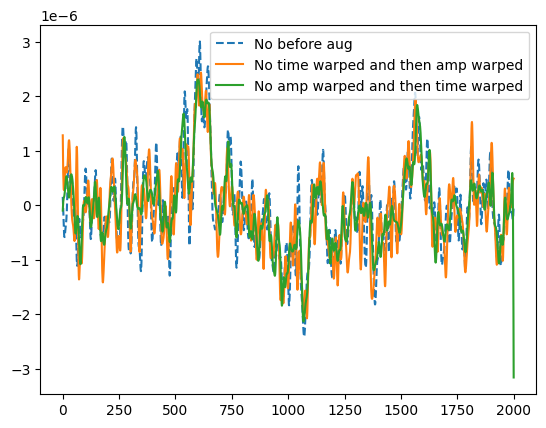

In [22]:
plt.plot(one_chan_mean_no_before, linestyle='--', label='No before aug')
plt.plot(one_chan_mean_no_t_a, linestyle='-', label='No time warped and then amp warped')
plt.plot(one_chan_mean_no_a_t, linestyle='-', label='No amp warped and then time warped')
plt.legend()

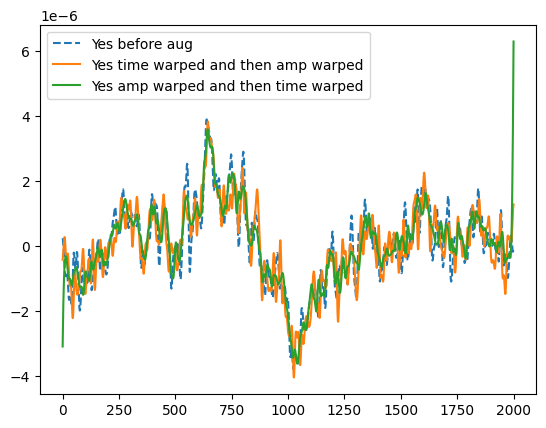

In [23]:
plt.plot(one_chan_mean_yes_before, linestyle='--', label='Yes before aug')
plt.plot(one_chan_mean_yes_t_a, linestyle='-', label='Yes time warped and then amp warped')
plt.plot(one_chan_mean_yes_a_t, linestyle='-', label='Yes amp warped and then time warped')
plt.legend()